## LSTM for time-series forecasting on water flow data gathered by the Karachi Water Project

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import scienceplots
import os

plt.style.use(['science','ieee'])

# 5-min Volume model

In [7]:
def read_data(n):
  url = "data_v8_vol_cleaned.csv"
  if n != None:
    df_raw = pd.read_csv(url, nrows=n)
  else:
    df_raw = pd.read_csv(url)
  return df_raw

In [8]:
def five_min_window(df_raw, scaler):
  df = df_raw.groupby(df_raw['5min_count']).sum().reset_index()
  df = df.loc[:,["volume"]]
  df = scaler.fit_transform(df)
  df = tf.convert_to_tensor(df)

  print("1. Data has been read")
  print("2. Data being sliced into windows")

  window_len = 12
  stride = 2

  assert len(df) > window_len + 1

  new = []
  for i in range(window_len, len(df), stride):
    if i % 10000 == 0:
      print(i, "/", len(df))
    new.append([df[i-window_len:i], df[i]])

  df = new

  train_ratio = 0.8
  sequence_len = len(df)

  train_data = df[0:int(sequence_len*train_ratio)]
  test_data = df[int(sequence_len*train_ratio):]

  print("3. Completed")

  return train_data, test_data, scaler

In [9]:
df_raw = read_data(n=None)

In [10]:
scaler = StandardScaler() 
train_data, test_data, scaler = five_min_window(df_raw, scaler)

# Initialize sentences and labels lists
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []


# Loop over all training examples 
for datax, datay in zip(train_data, test_data):
  training_sentences.append(np.array(datax[0]))
  training_labels.append(datax[1])
  testing_sentences.append(np.array(datay[0]))
  testing_labels.append(datay[1])

# Convert labels lists to numpy array
training_sentences = np.array(training_sentences)
training_labels = np.array(training_labels)
testing_sentences = np.array(testing_sentences)
testing_labels = np.array(testing_labels)

1. Data has been read
2. Data being sliced into windows
10000 / 65588
20000 / 65588
30000 / 65588
40000 / 65588
50000 / 65588
60000 / 65588
3. Completed


In [11]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, input_shape=(training_sentences.shape[1], training_sentences.shape[2]), activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation='tanh', return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh')),
    tf.keras.layers.Dense(40, activation='linear'),
    tf.keras.layers.Dense(30, activation='linear'),
    tf.keras.layers.Dense(20, activation='linear'),
    tf.keras.layers.Dense(10, activation='linear'),
    tf.keras.layers.Dense(1, activation='linear')
])

Epoch 1/100
26/26 [==============================] - 34s 276ms/step - loss: 0.1176 - mean_squared_error: 0.1176 - val_loss: 3.1803 - val_mean_squared_error: 3.1803
Epoch 2/100
26/26 [==============================] - 2s 87ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - val_loss: 3.1738 - val_mean_squared_error: 3.1738
Epoch 3/100
26/26 [==============================] - 2s 77ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - val_loss: 3.1605 - val_mean_squared_error: 3.1605
Epoch 4/100
26/26 [==============================] - 2s 81ms/step - loss: 0.0142 - mean_squared_error: 0.0142 - val_loss: 3.1495 - val_mean_squared_error: 3.1495
Epoch 5/100
26/26 [==============================] - 2s 81ms/step - loss: 0.0141 - mean_squared_error: 0.0141 - val_loss: 3.1659 - val_mean_squared_error: 3.1659
Epoch 6/100
26/26 [==============================] - 2s 79ms/step - loss: 0.0141 - mean_squared_error: 0.0141 - val_loss: 3.1357 - val_mean_squared_error: 3.1357
Epoch 7/100
26/26 [=======

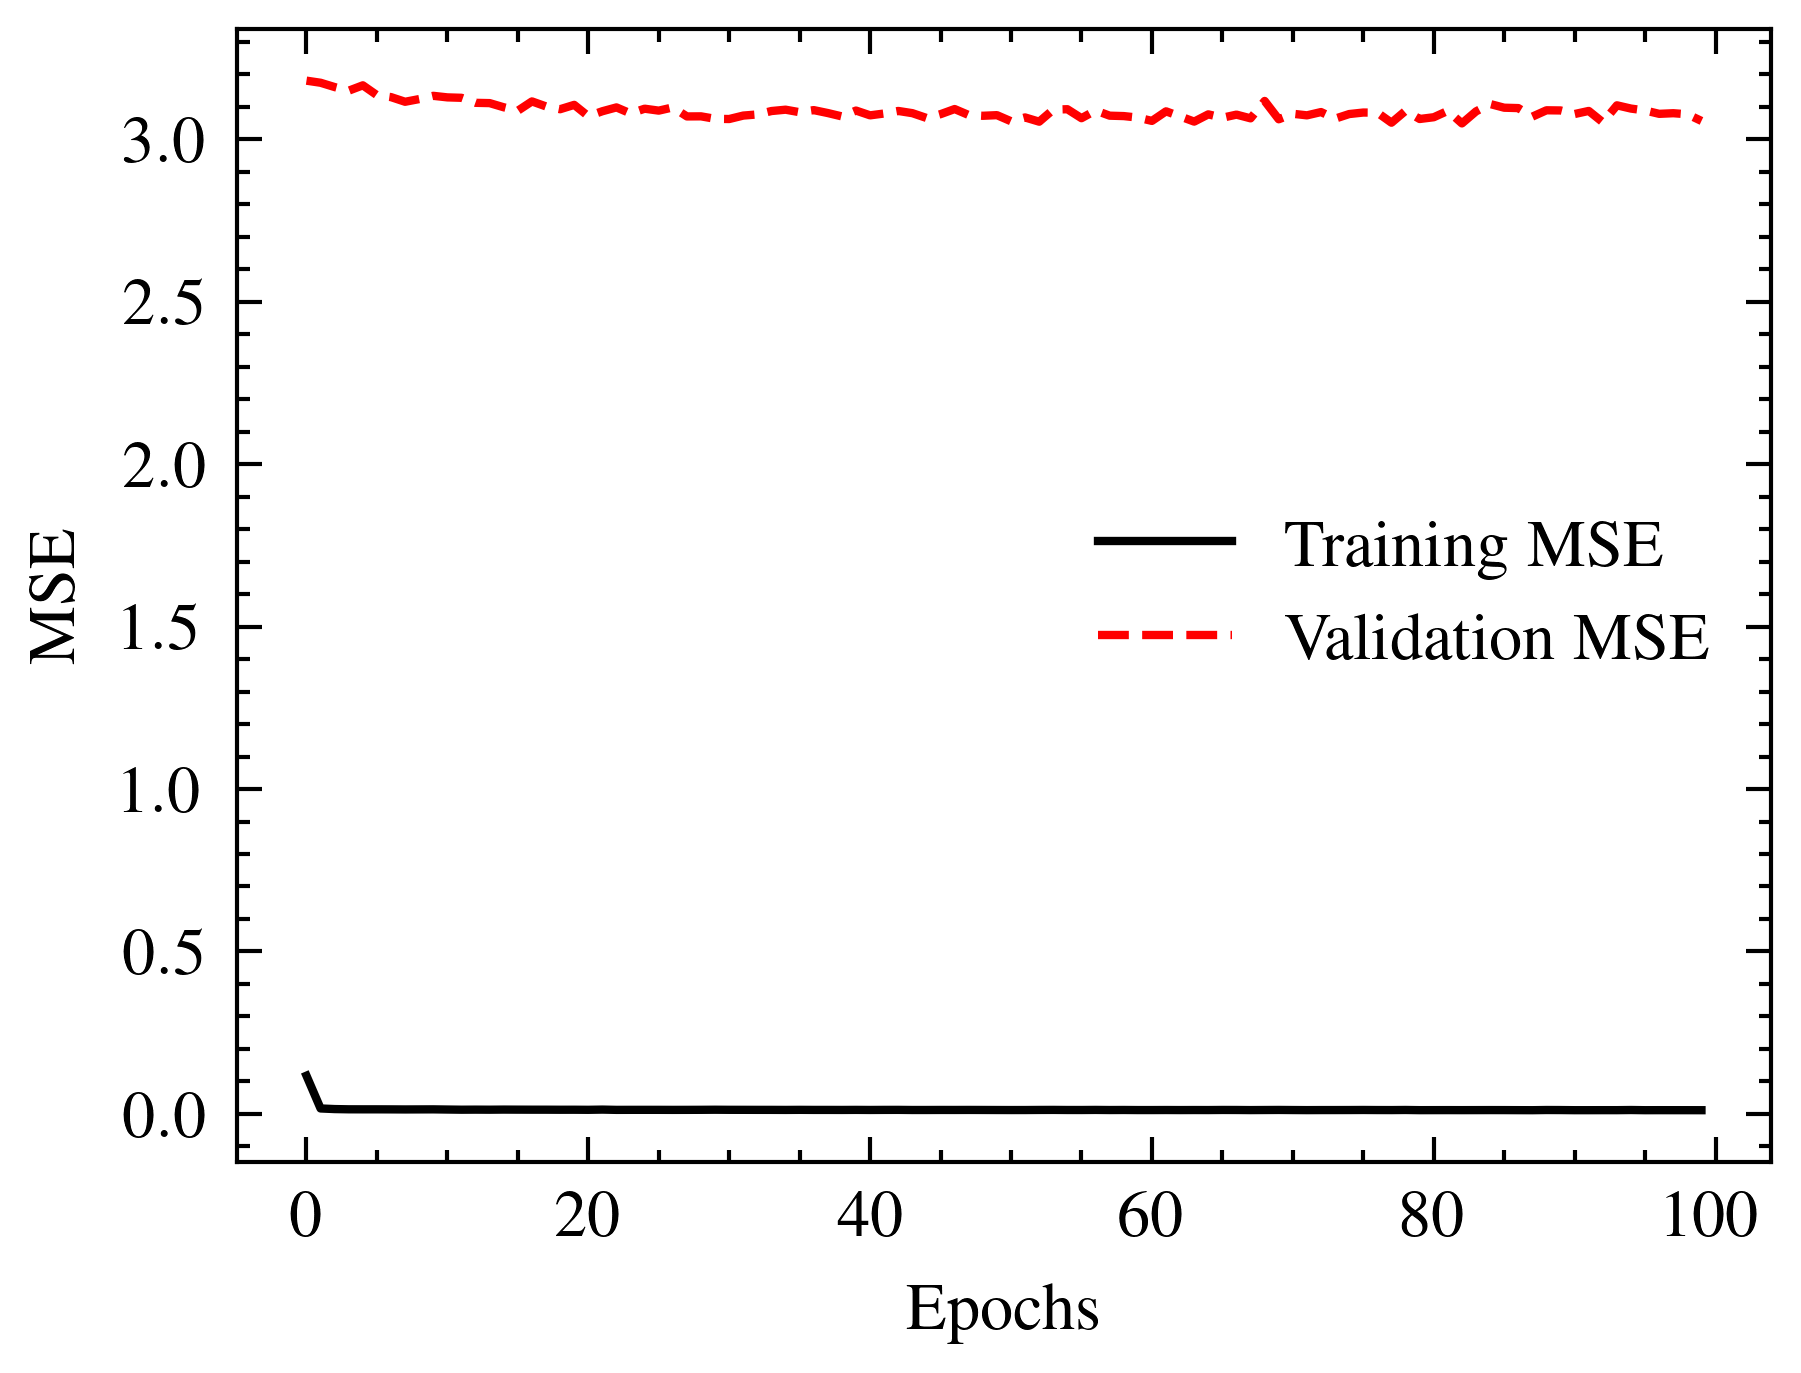

In [12]:
# Set the training parameters
model_lstm.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['mean_squared_error']) 

NUM_EPOCHS = 100
BATCH_SIZE = 256

# Train the model
history_lstm = model_lstm.fit(x=training_sentences, y=training_labels, 
                                    epochs=NUM_EPOCHS, 
                                    validation_data=(testing_sentences, testing_labels), 
                                    batch_size=BATCH_SIZE)
# Print the model summary
model_lstm.summary()

plt.plot(history_lstm.history['mean_squared_error'])
plt.plot(history_lstm.history['val_'+'mean_squared_error'])
plt.xlabel("Epochs")
plt.ylabel('MSE')
plt.legend(['Training MSE', 'Validation MSE'])
plt.show()

205/205 [==============================] - 8s 19ms/step


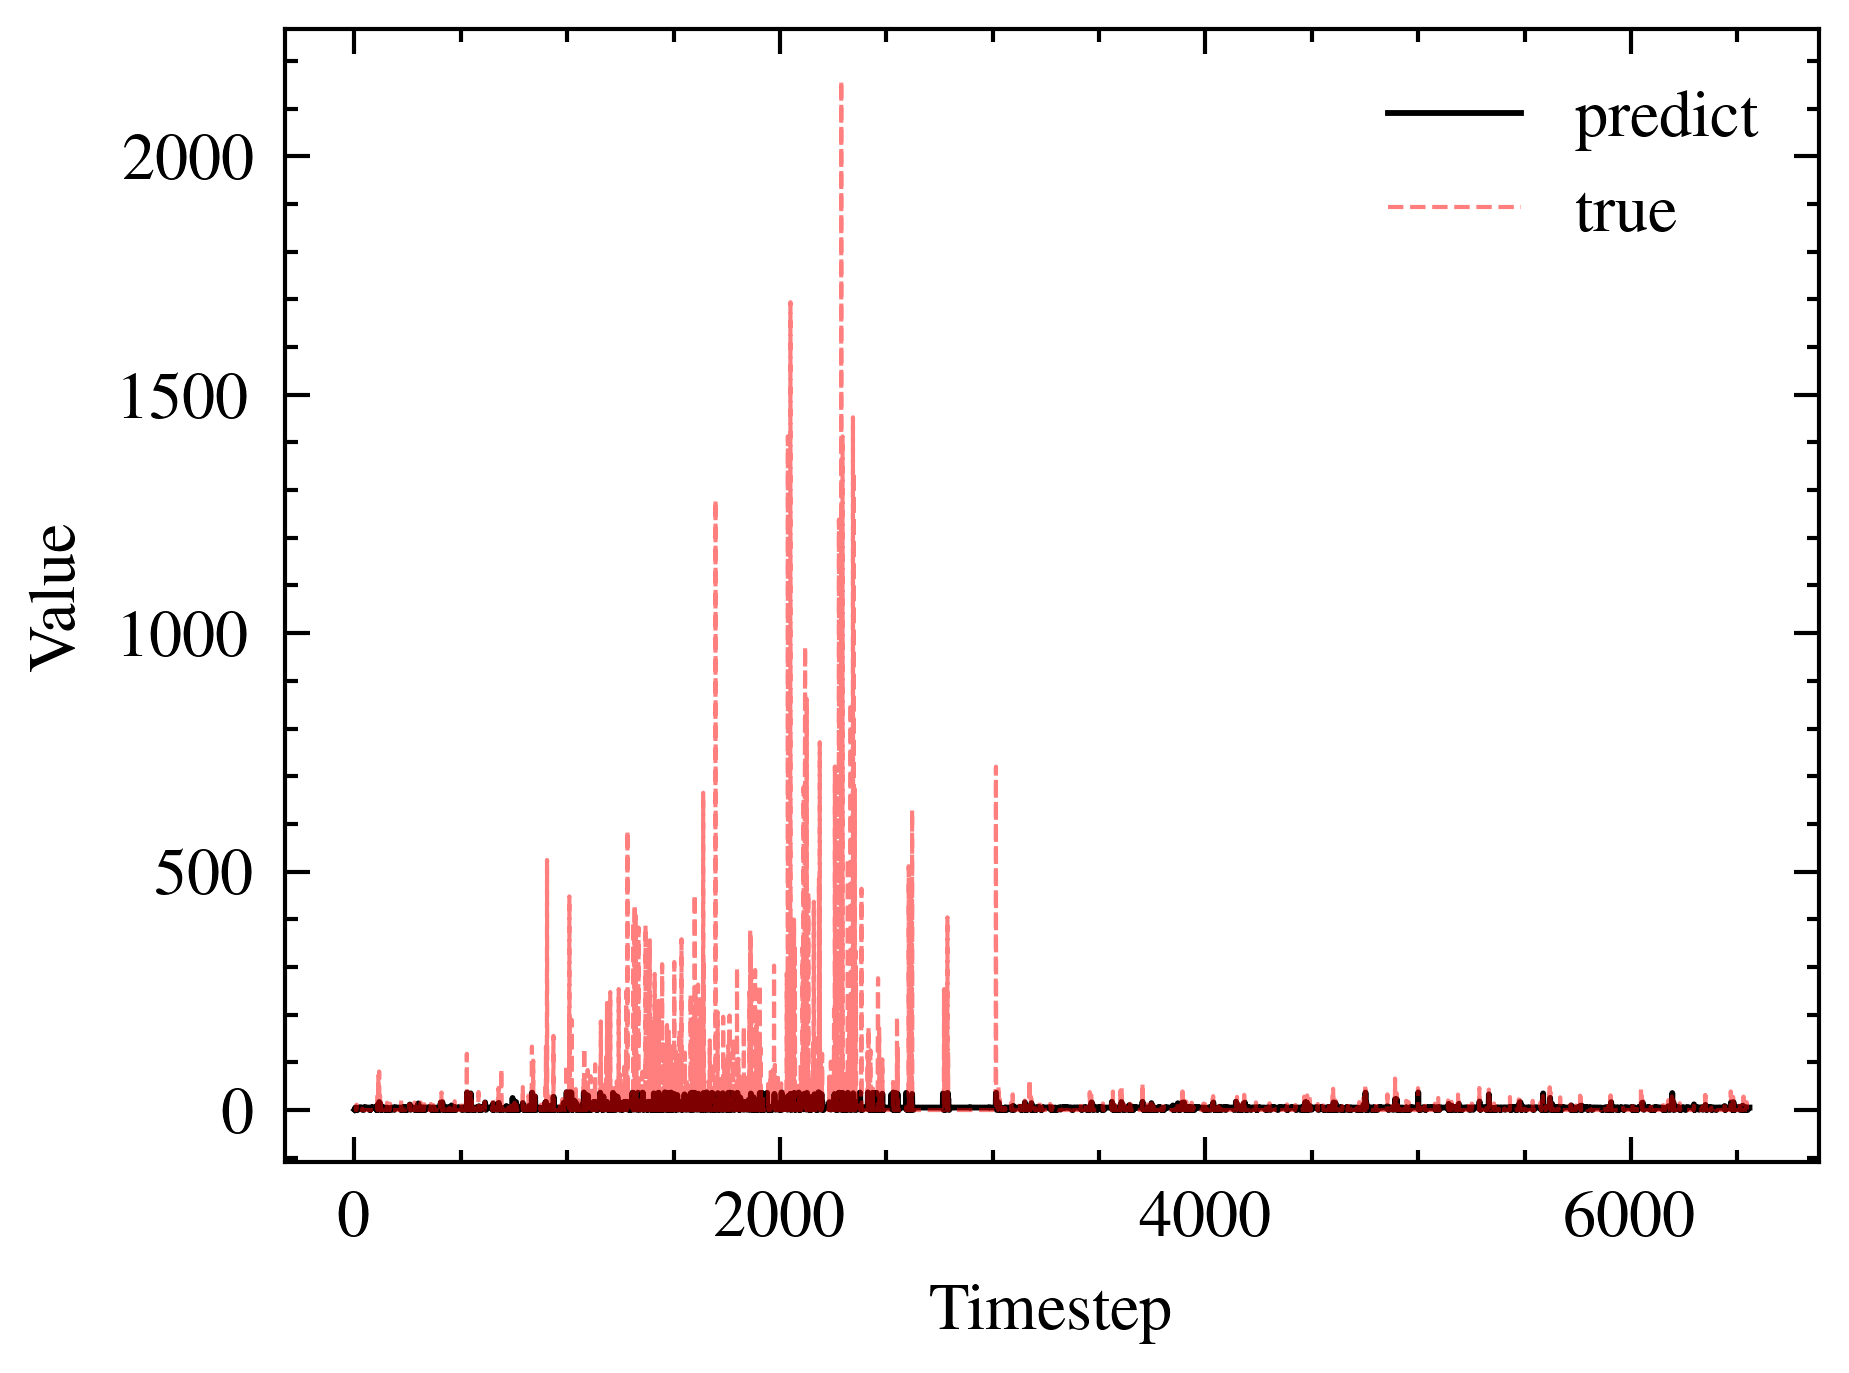

In [13]:
predict = model_lstm.predict(testing_sentences)
predict = scaler.inverse_transform(predict)
plt.plot(predict, label="predict", linewidth=0.7, alpha=1.0)
testing_labels = scaler.inverse_transform(testing_labels)
plt.plot([i for i in range(testing_labels.shape[0])], testing_labels, linewidth=0.5, label="true", alpha=0.5)
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.show()